# Typology for doubles

1. Identify 2-artifact clusters (pairs of contiguous artifacts); make sure that the union has no interior
2. For each cluster, classify the inside edge as C or nonC (`drop_interline`: bool)
3. Visualize and test if it works

- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

In [1]:
import logging

import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from scipy import sparse, spatial
import folium
import folium.plugins as plugins
import shapely

from core import algorithms, utils
from core.geometry import voronoi_skeleton, remove_false_nodes

In [2]:
import warnings

# Filter out the RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in intersection")

In [3]:
# Get the logger for core.algorithms.simplify
logger = logging.getLogger("core.algorithms.simplify")
logger.setLevel(logging.DEBUG)

# Set the logging format
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

# Create a handler for the logger
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

Specify case metadata

In [4]:
case = "Liège"

Read road data

In [5]:
roads = utils.read_original(case)

Remove duplicated roads

In [6]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Merge nearby nodes (up to double of distance used in skeleton).

In [7]:
roads = algorithms.simplify.consolidate_nodes(roads, tolerance=4)

Identify artifacts

In [8]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [9]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Filter doubles

In [10]:
rook = graph.Graph.build_contiguity(artifacts, rook=True)
artifacts["comp"] = rook.component_labels
counts = artifacts["comp"].value_counts()
artifacts = artifacts.loc[artifacts["comp"].isin(counts[counts == 2].index)]

Optionally define a subset of data.

In [11]:
def get_type(edges, shared_edge):
    if (  # roundabout special case
        edges.coins_group.nunique() == 1 and edges.shape[0] == edges.coins_count.iloc[0]
    ):
        return "S"

    all_ends = edges[edges.coins_end]
    mains = edges[~edges.coins_group.isin(all_ends.coins_group)]
    shared = edges.loc[shared_edge]
    if shared_edge in mains.index:
        return "C"
    if shared.coins_count == (edges.coins_group == shared.coins_group).sum():
        return "S"
    return "E"


def get_solution(group, roads):
    cluster_geom = group.union_all(method="coverage")

    # find the road segment that is contained within the cluster geometry
    shared = roads.index[roads.sindex.query(cluster_geom, predicate="contains")].item()
    seen_by_a = get_type(
        roads.iloc[roads.sindex.query(group.geometry.iloc[0], predicate="covers")],
        shared,
    )
    seen_by_b = get_type(
        roads.iloc[roads.sindex.query(group.geometry.iloc[1], predicate="covers")],
        shared,
    )
    if seen_by_a == "C" and seen_by_b == "C":
        return pd.Series({"solution": "iterate", "drop_id": shared})
    if seen_by_a == seen_by_b:
        return pd.Series({"solution": "drop_interline", "drop_id": shared})
    return pd.Series({"solution": "skeleton", "drop_id": shared})

In [12]:
distance = 2

In [13]:
data_sample = artifacts.sort_values("comp").iloc[120:].copy()
artifacts = data_sample[data_sample.comp == 588].copy()

In [14]:
def simplify_pairs(artifacts, roads, distance=2):
    # Get nodes from the network.
    nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

    # Link nodes to artifacts
    node_idx, artifact_idx = artifacts.sindex.query(
        nodes.buffer(0.1), predicate="intersects"
    )
    intersects = sparse.coo_array(
        ([True] * len(node_idx), (node_idx, artifact_idx)),
        shape=(len(nodes), len(artifacts)),
        dtype=np.bool_,
    )

    # Compute number of nodes per artifact
    artifacts["node_count"] = intersects.sum(axis=0)

    # Compute number of stroke groups per artifact
    roads, _ = algorithms.common.continuity(roads)
    strokes, c_, e_, s_ = algorithms.common.get_stroke_info(artifacts, roads)

    artifacts["stroke_count"] = strokes
    artifacts["C"] = c_
    artifacts["E"] = e_
    artifacts["S"] = s_

    # Filer artifacts caused by non-planar intersections.
    artifacts["non_planar"] = artifacts["stroke_count"] > artifacts["node_count"]
    a_idx, _ = roads.sindex.query(artifacts.geometry.boundary, predicate="overlaps")
    artifacts.loc[artifacts.index[np.unique(a_idx)], "non_planar"] = True

    # Remove (for now) the clusters that contain at least one non-planar component
    # (TODO: we will deal with them later, ...?)
    # non_planar_cluster: number of non-planar artifacts per cluster
    artifacts["non_planar_cluster"] = artifacts.apply(
        lambda x: sum(artifacts.loc[artifacts["comp"] == x.comp]["non_planar"]), axis=1
    )
    np_clusters = artifacts[artifacts.non_planar_cluster > 0]
    artifacts_planar = artifacts[artifacts.non_planar_cluster == 0]

    artifacts_w_info = artifacts.merge(
        artifacts_planar.groupby("comp").apply(get_solution, roads=roads),
        left_on="comp",
        right_index=True,
    )
    to_drop = (
        artifacts_w_info.drop_duplicates("comp").query("solution == 'drop_interline'").drop_id
    )
    merged_pairs = artifacts_w_info.query("solution == 'drop_interline'").dissolve(
        "comp", as_index=False
    )

    sorted_by_node_count = artifacts_w_info.sort_values("node_count", ascending=False)
    first = sorted_by_node_count.query("solution == 'iterate'").drop_duplicates("comp", keep="first")
    second = sorted_by_node_count.query("solution == 'iterate'").drop_duplicates("comp", keep="last")

    first = pd.concat([first, np_clusters[~np_clusters.non_planar]], ignore_index=True)

    roads_cleaned = remove_false_nodes(
        roads.drop(to_drop.dropna().values),
        aggfunc={
            "coins_group": "first",
            "coins_end": lambda x: x.any(),
        },
    )
    coins_count = roads_cleaned.groupby("coins_group", as_index=False).geometry.count().rename(columns={"geometry": "coins_count"})
    roads_cleaned = roads_cleaned.merge(coins_count, on="coins_group", how="left")

    loop_1 = algorithms.simplify.simplify_singletons(
        pd.concat([merged_pairs, first]),
        roads_cleaned,
        distance=distance,
        compute_coins=False,
    )
    loop_2 = algorithms.simplify.simplify_singletons(
        second, loop_1, distance=distance, compute_coins=True
    )
    loop_3 = algorithms.simplify.simplify_clusters(

        artifacts_w_info.query("solution == 'skeleton'"), loop_2
    )
    return loop_3

In [15]:
new_roads = simplify_pairs(data_sample, roads)

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_93778/3574562699.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  artifacts_planar.groupby("comp").apply(get_solution, roads=roads),
2024-07-29 22:48:45,464 - core.algorithms.simplify - DEBUG - FUNCTION nx_gx
2024-07-29 22:48:45,465 - core.algorithms.simplify - DEBUG - HIGHEST C
2024-07-29 22:48:45,472 - core.algorithms.simplify - DEBUG - CONDITION n_comps > 1 True
2024-07-29 22:48:45,476 - core.algorithms.simplify - DEBUG - CONDITION len(highest_hierarchy) > 1 True
2024-07-29 22:48:45,477 - core.algorithms.simplify - DEBUG - CONDITION for CCSS special case False
2024-07-29 22:48:45,496 - core.algorithms.simplify - DEBUG - FUNCTION nx

342


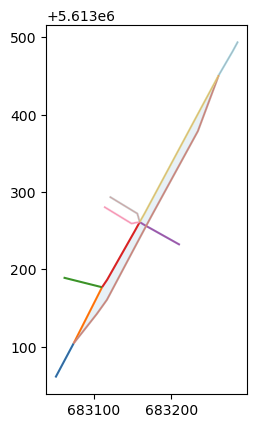

344


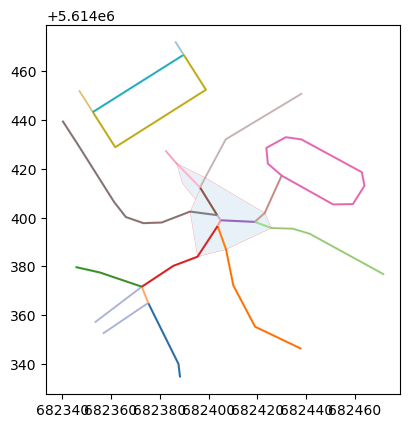

346


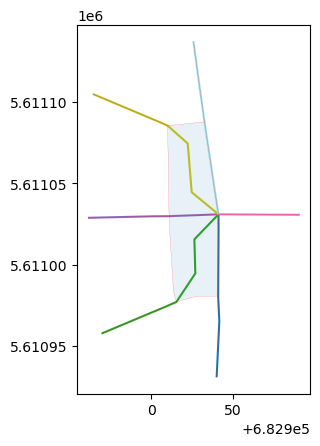

348


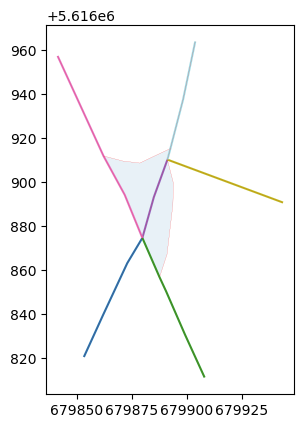

350


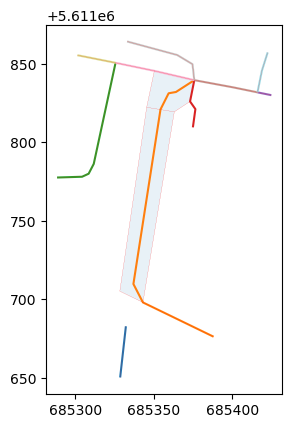

360


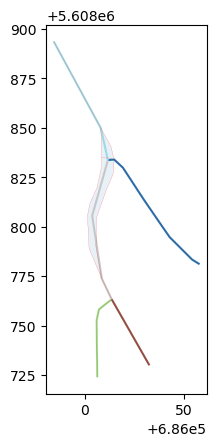

362


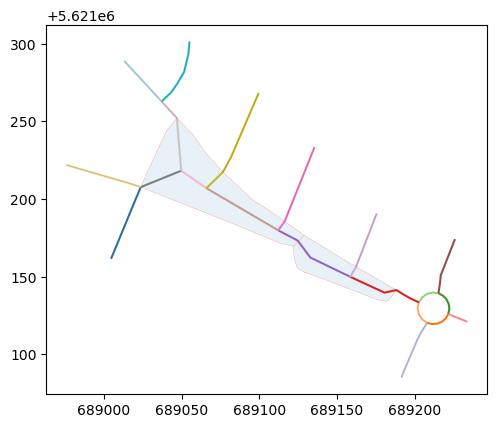

372


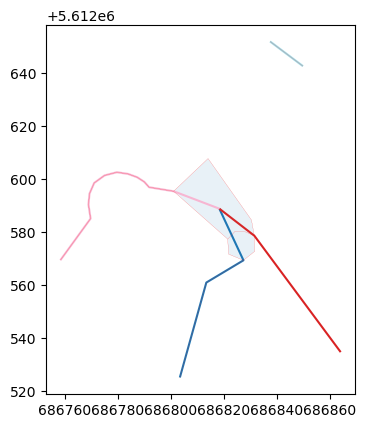

374


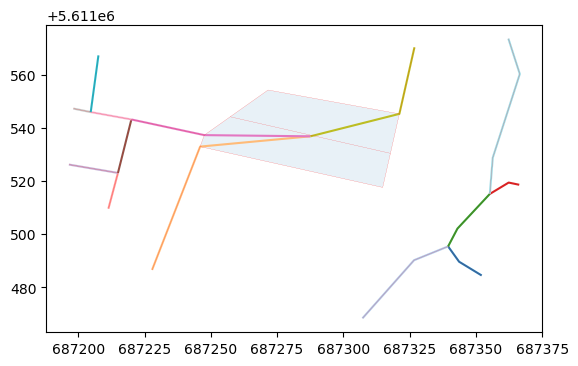

392


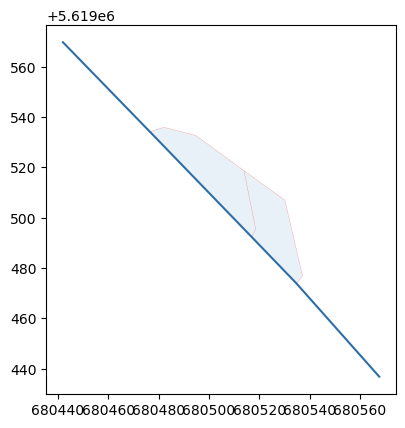

394


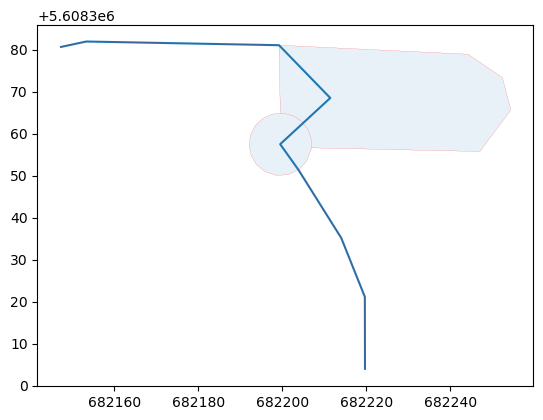

395


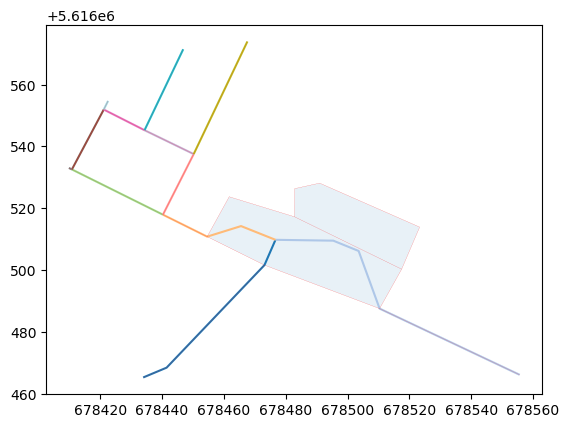

400


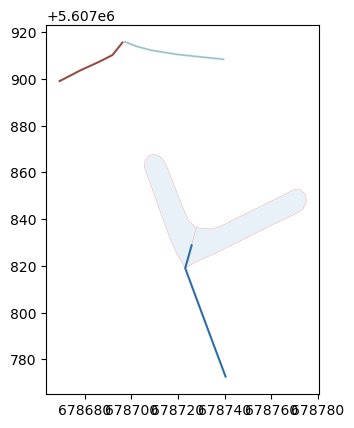

407


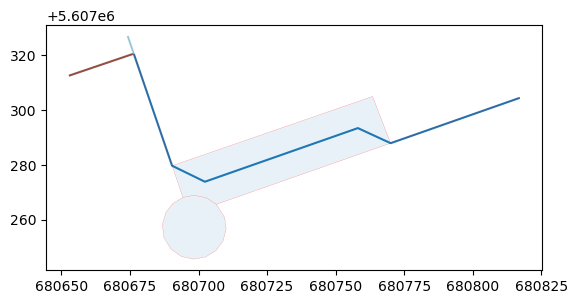

409


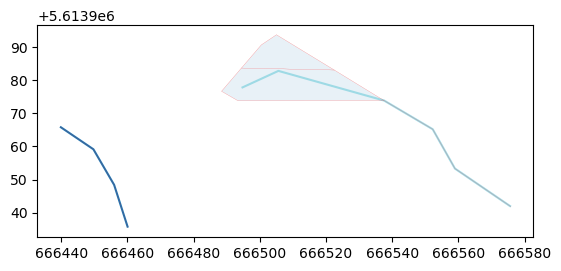

416


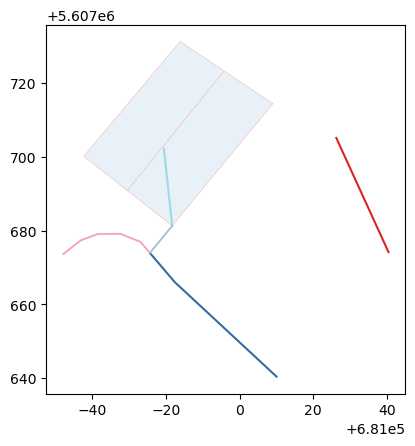

424


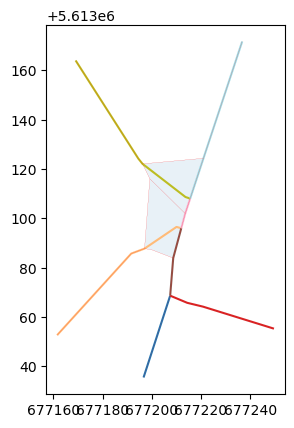

425


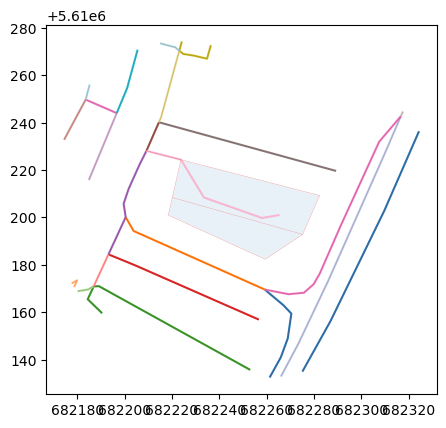

426


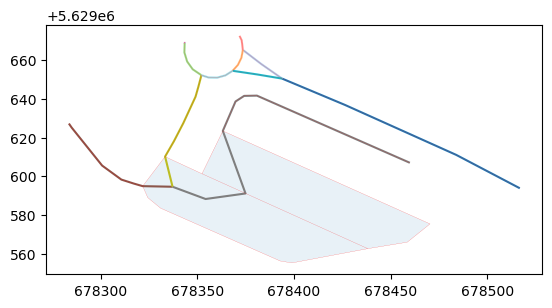

431


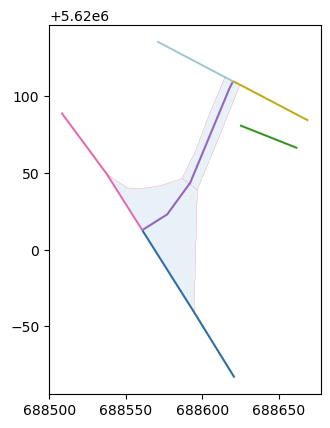

434


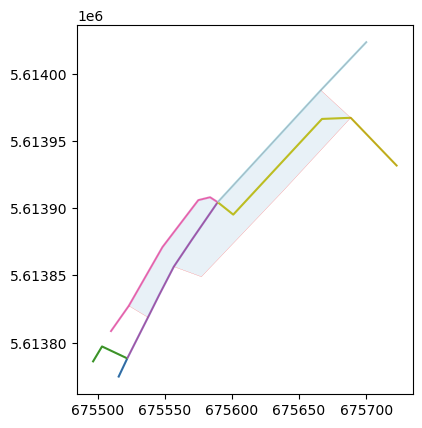

435


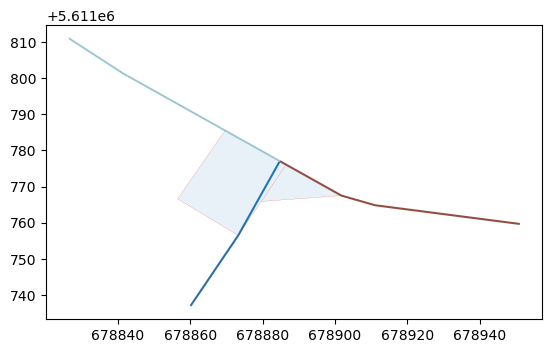

438


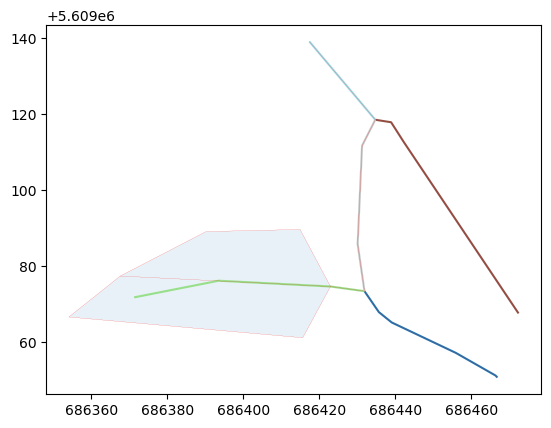

441


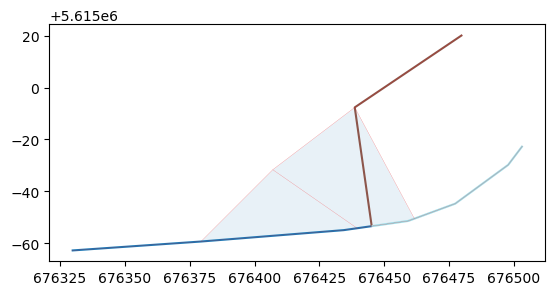

442


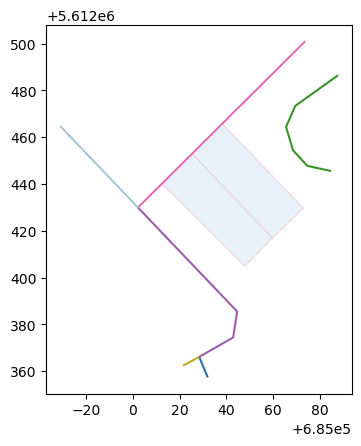

443


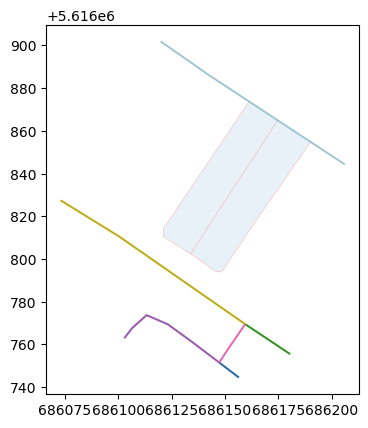

444


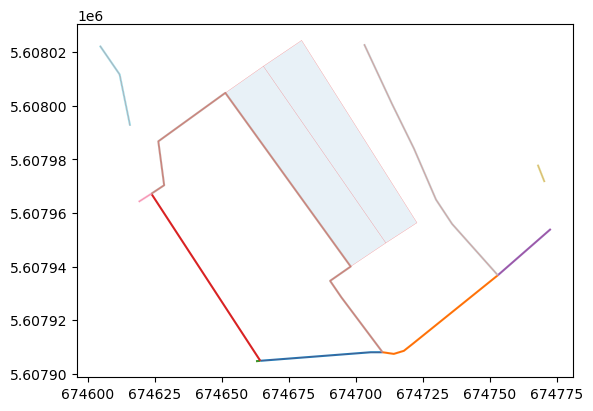

446


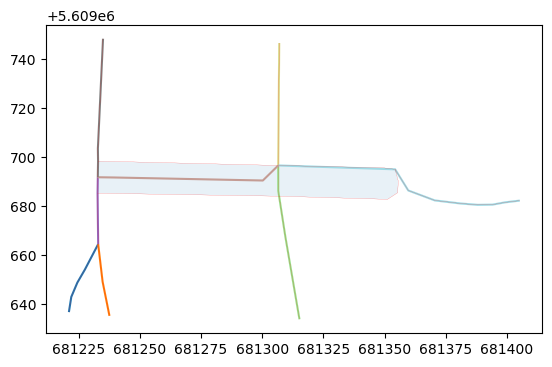

452


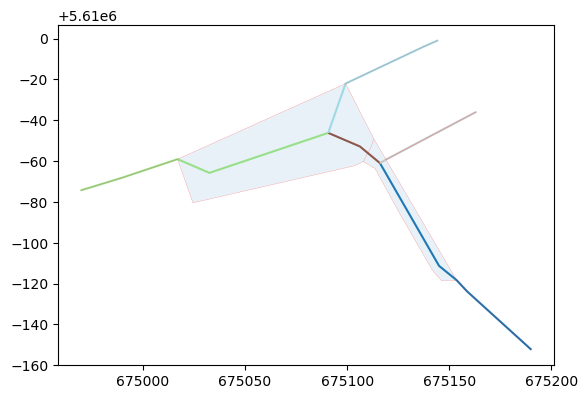

458


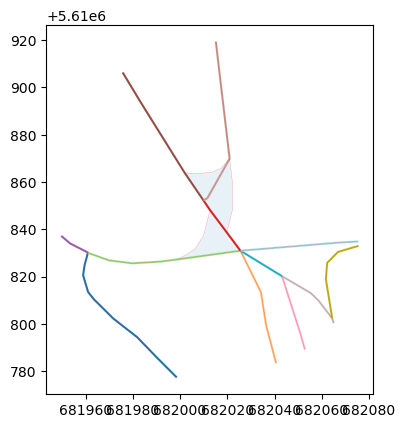

467


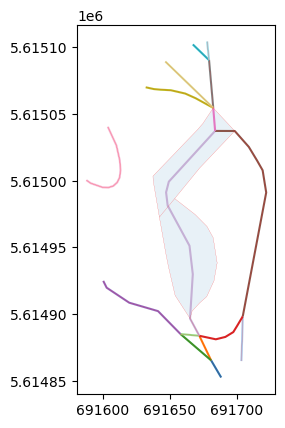

471


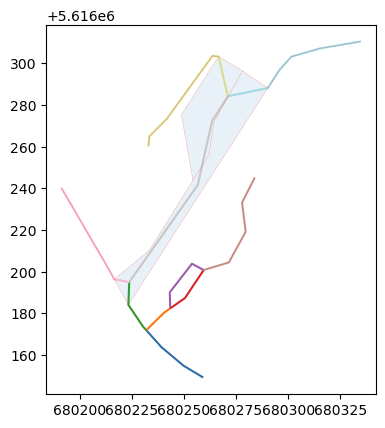

482


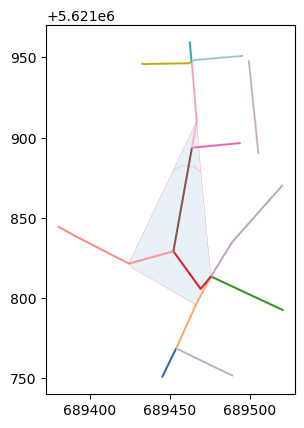

483


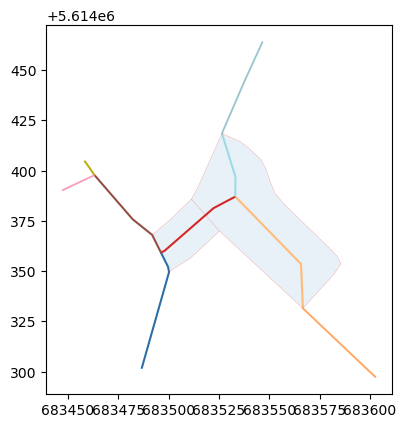

521


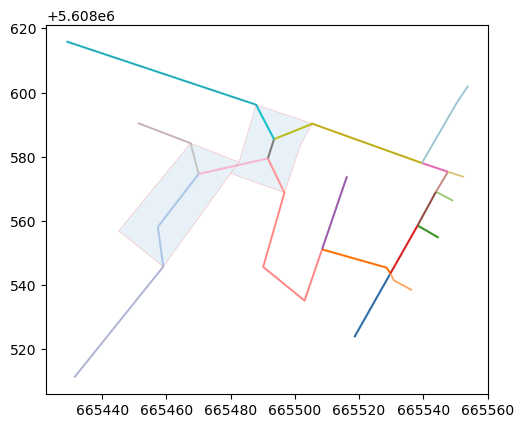

523


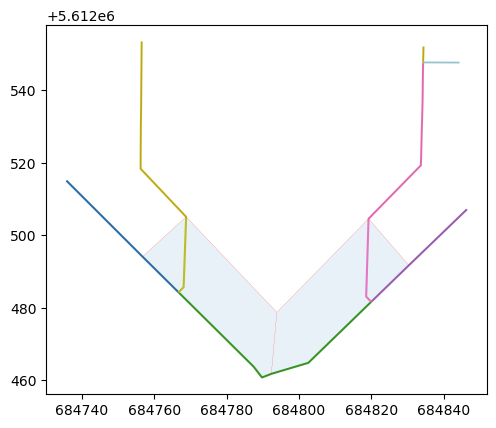

524


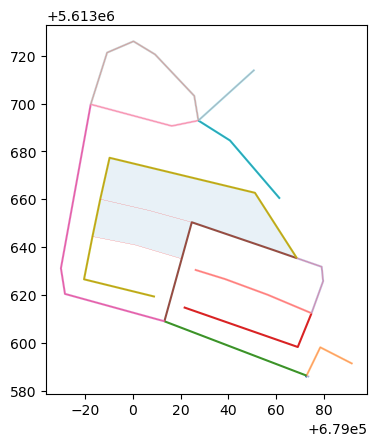

525


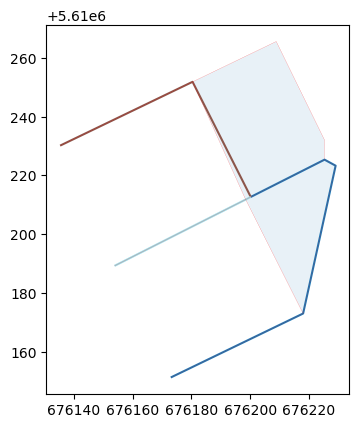

538


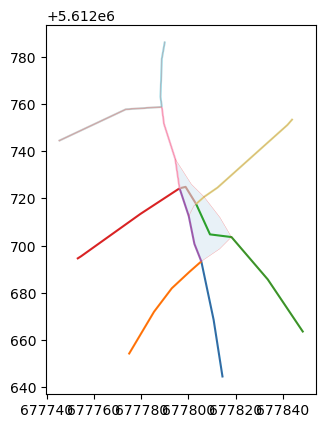

539


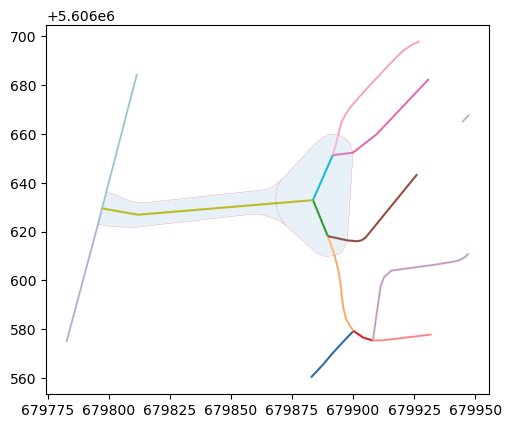

540


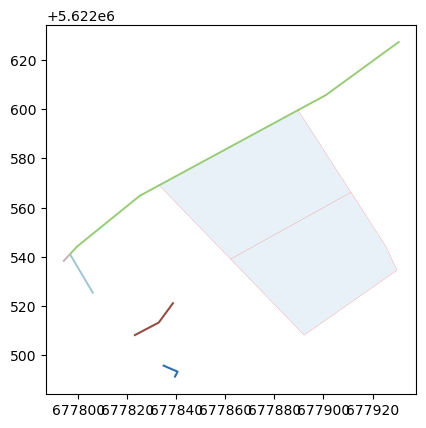

541


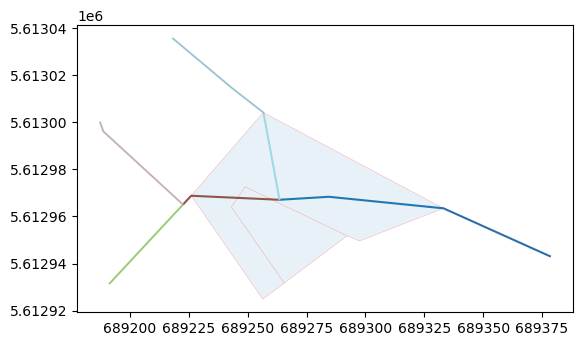

550


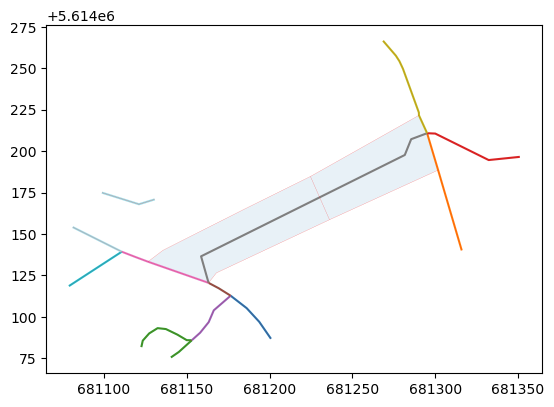

552


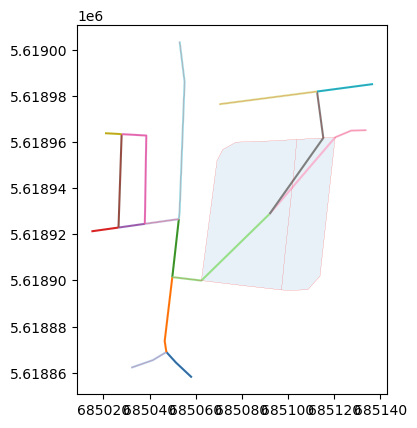

559


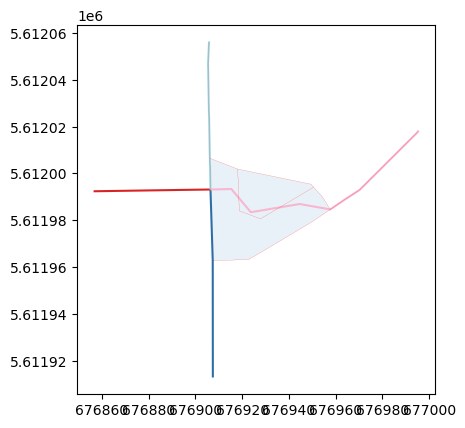

560


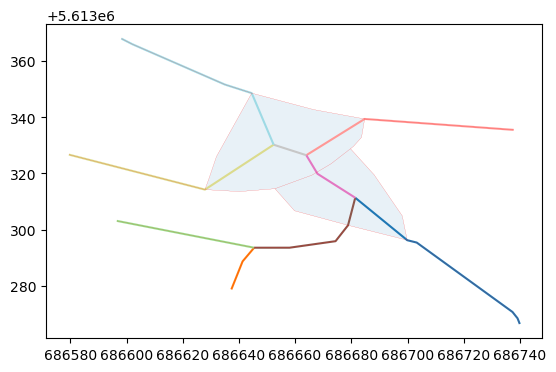

562


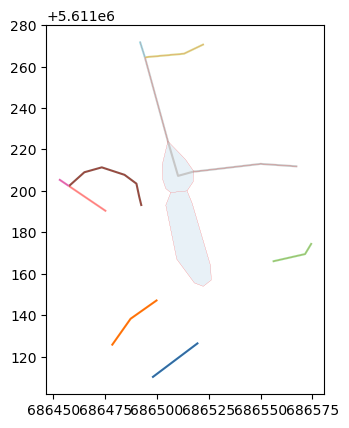

566


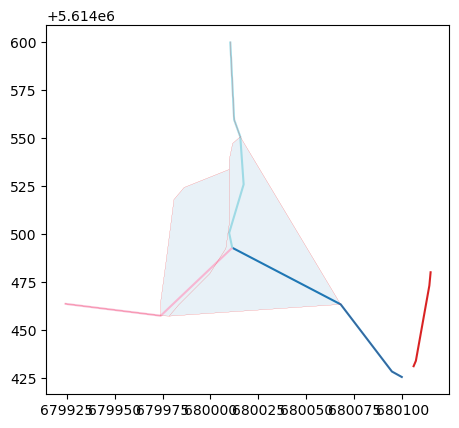

570


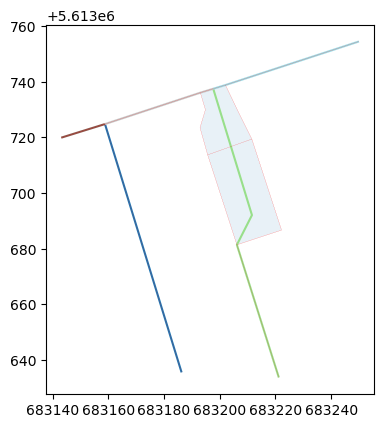

572


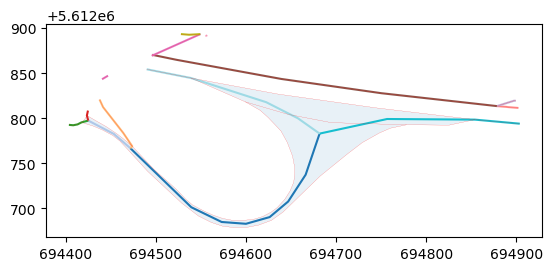

594


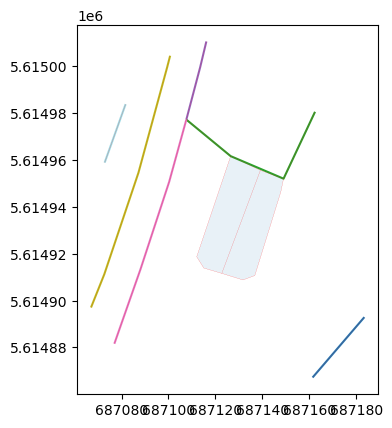

605


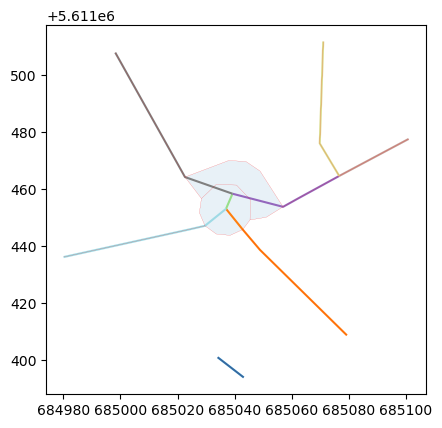

609


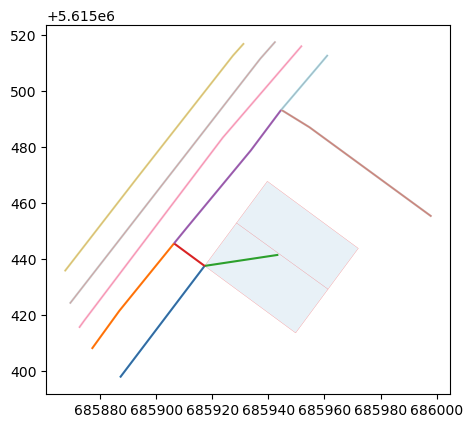

611


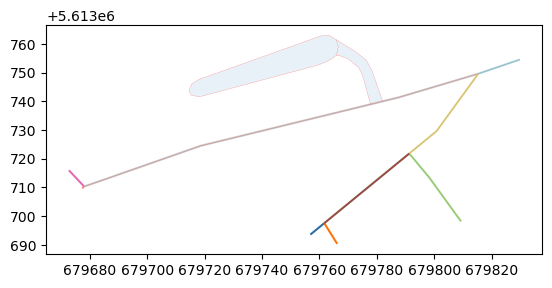

618


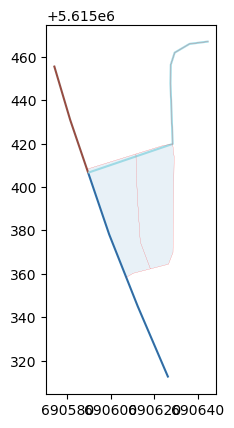

619


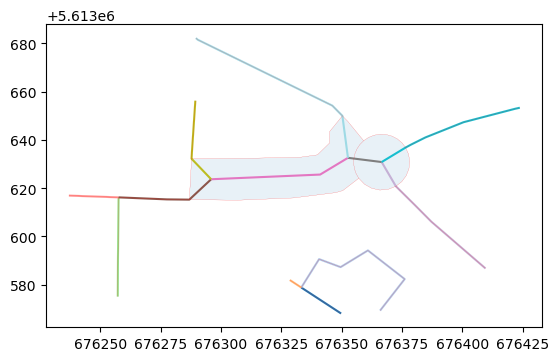

621


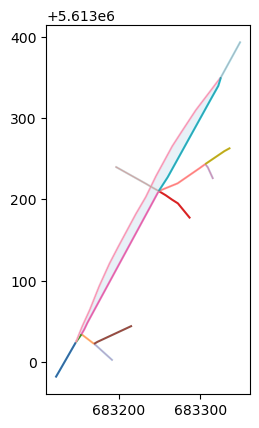

624


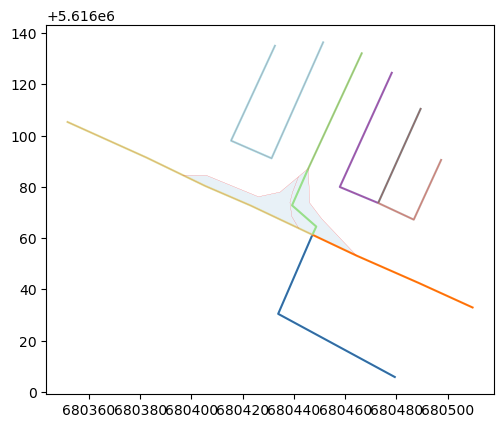

631


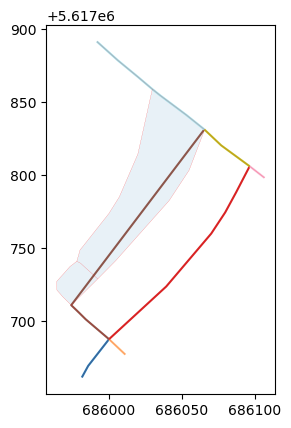

632


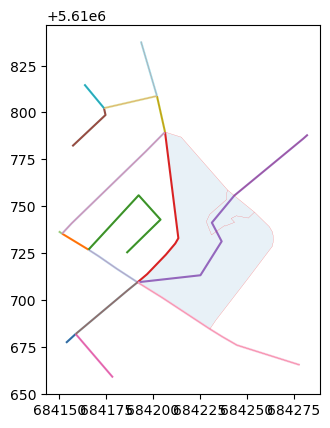

635


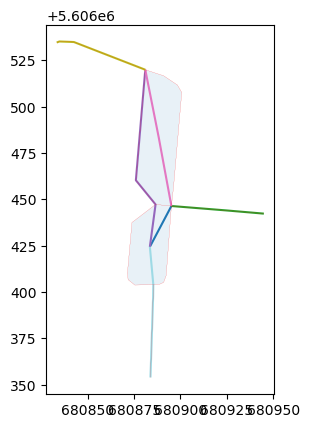

640


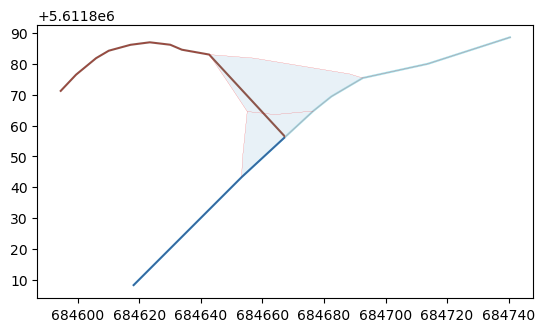

641


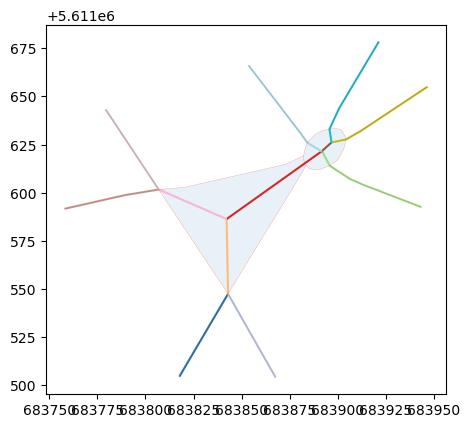

645


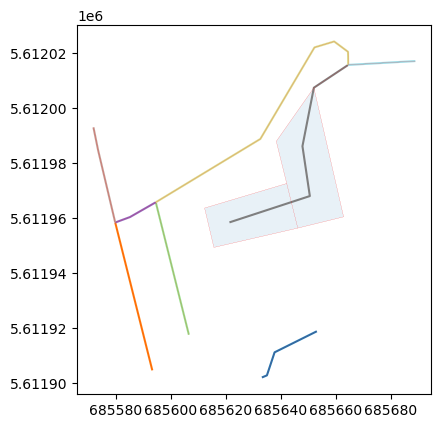

656


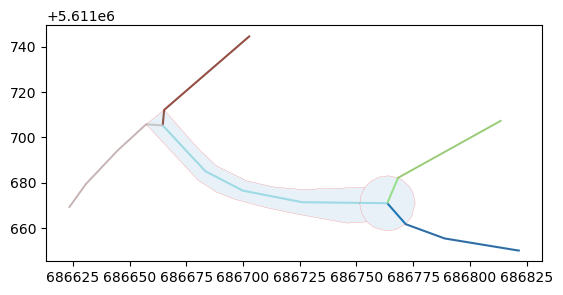

665


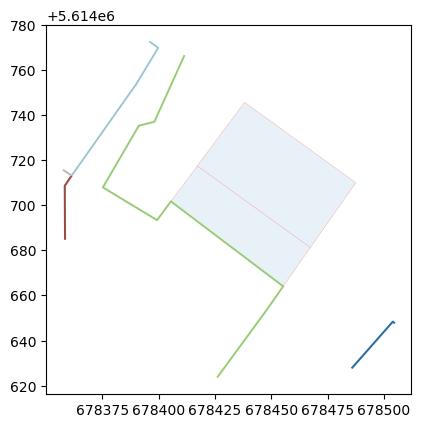

670


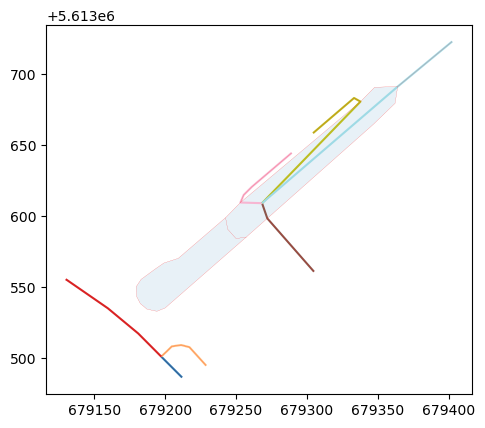

678


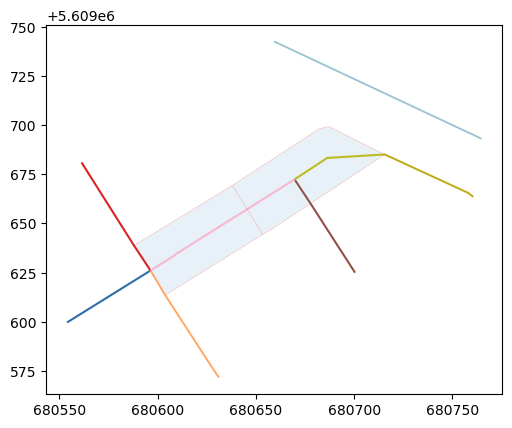

683


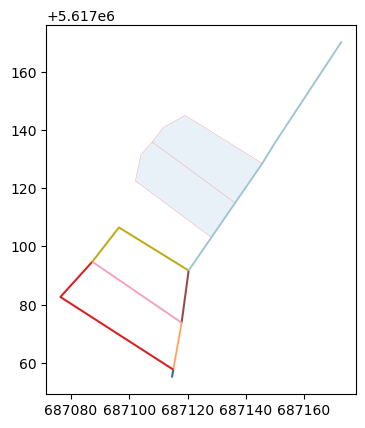

687


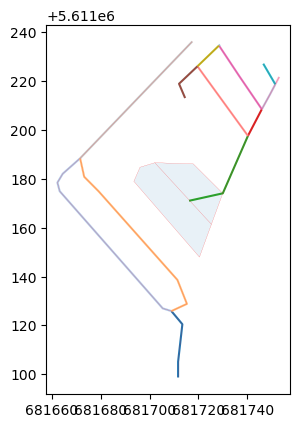

689


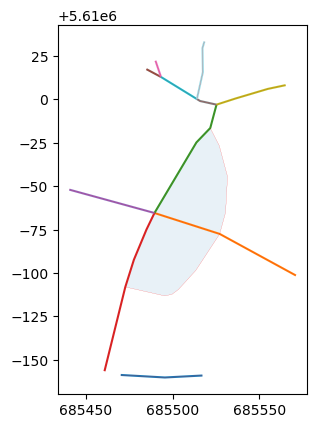

698


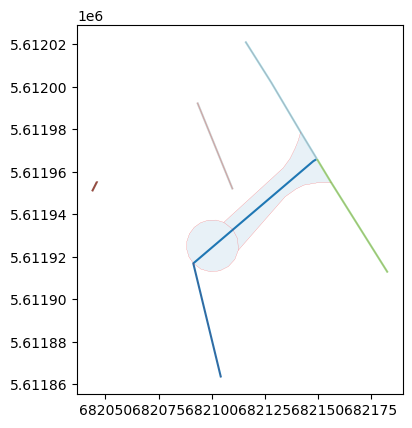

706


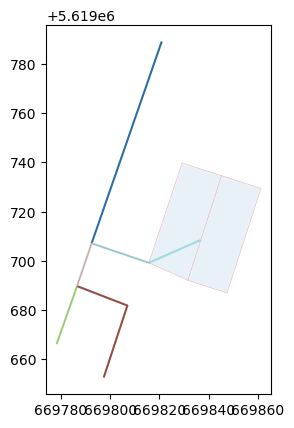

713


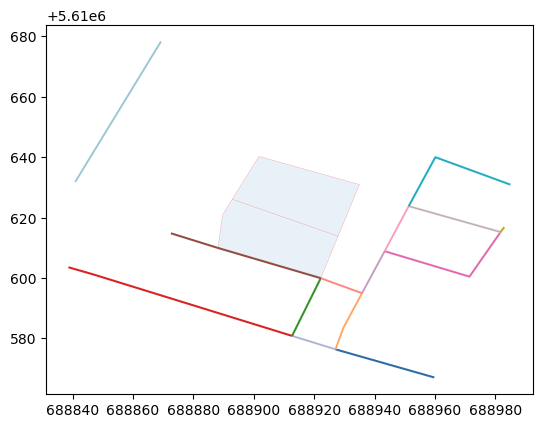

718


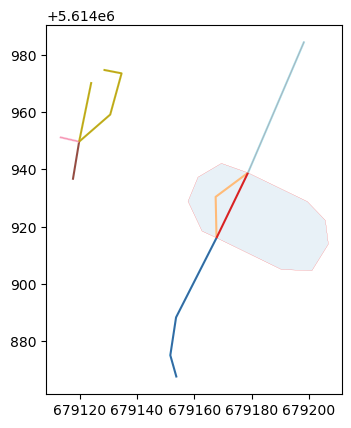

719


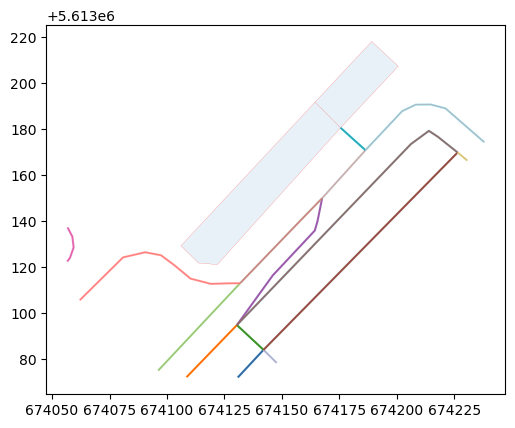

738


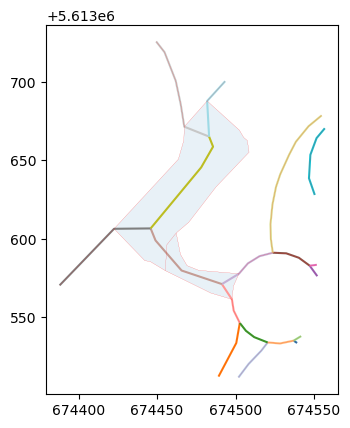

742


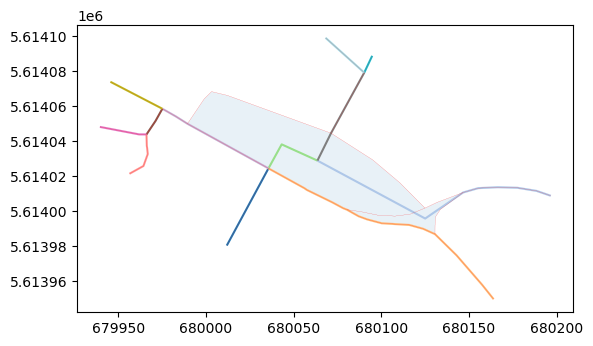

748


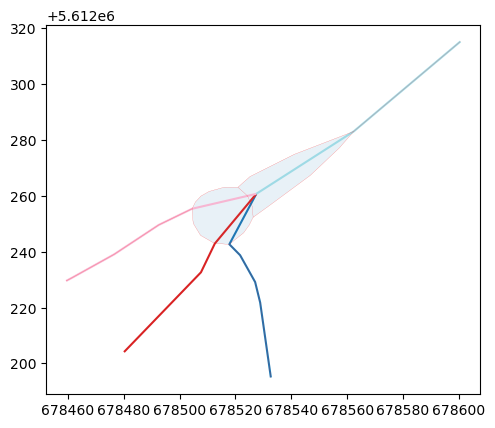

755


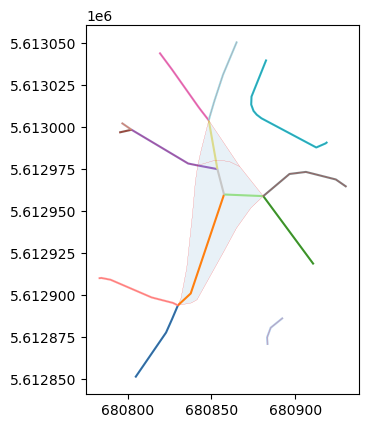

768


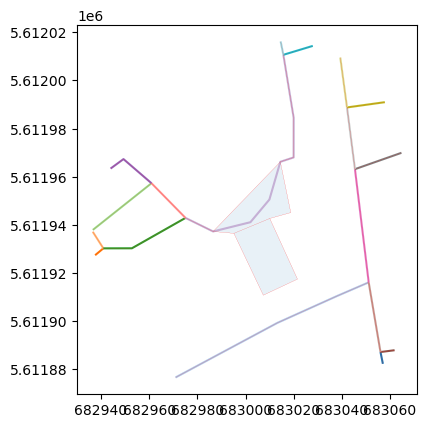

773


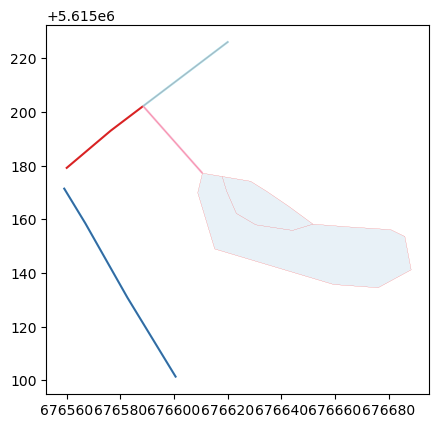

797


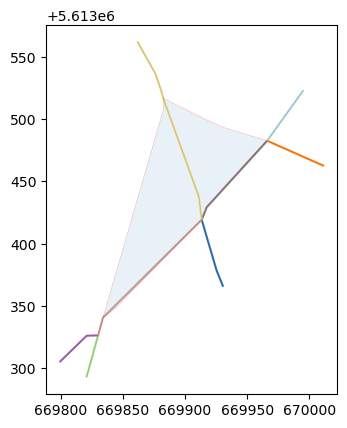

815


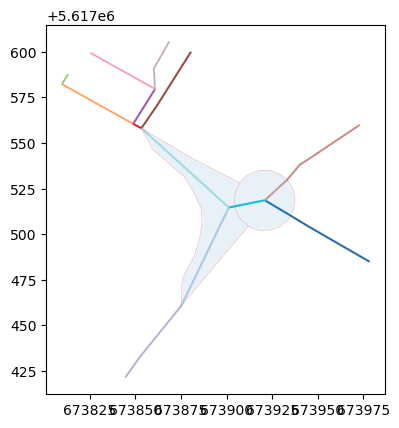

834


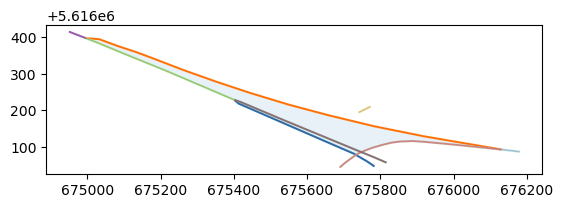

835


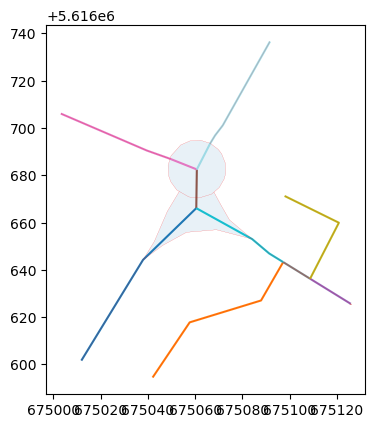

841


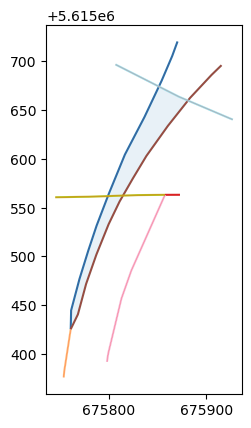

858


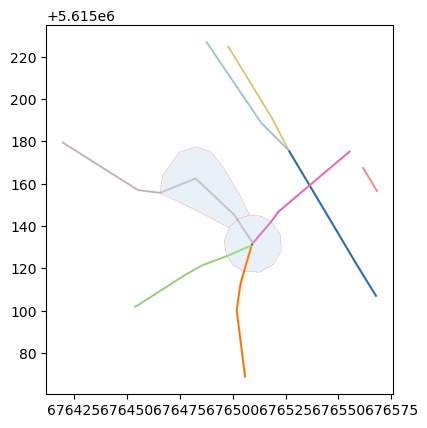

871


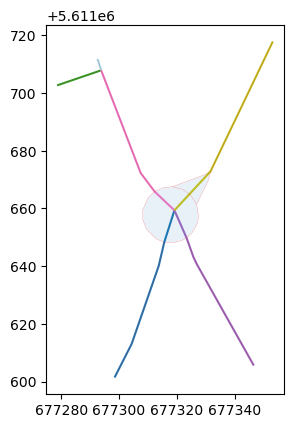

882


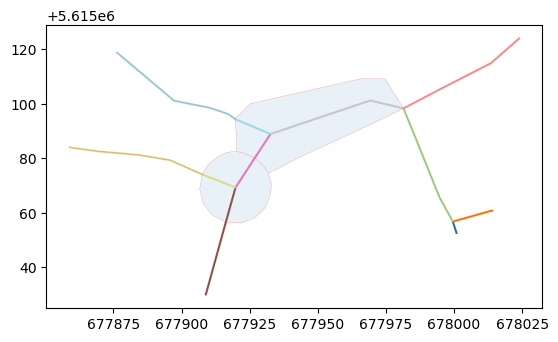

885


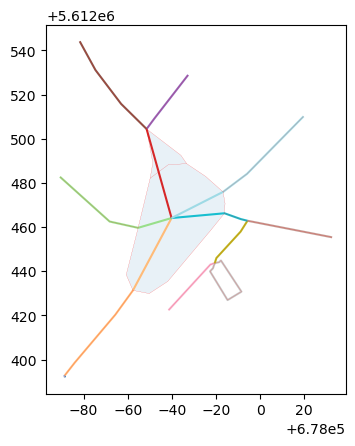

901


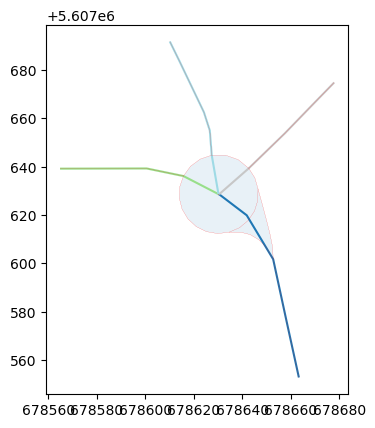

907


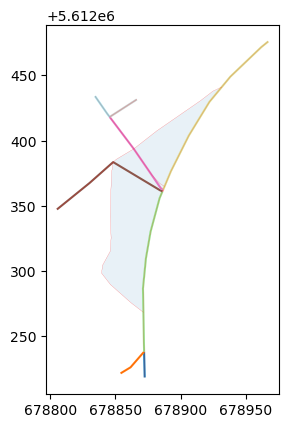

926


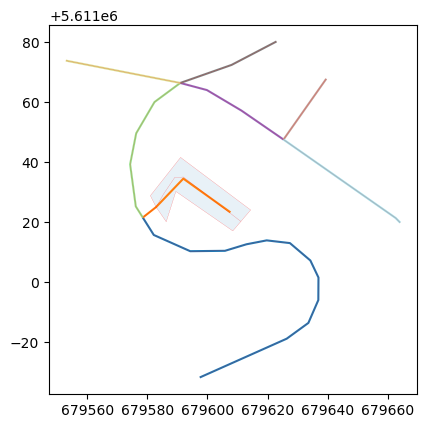

930


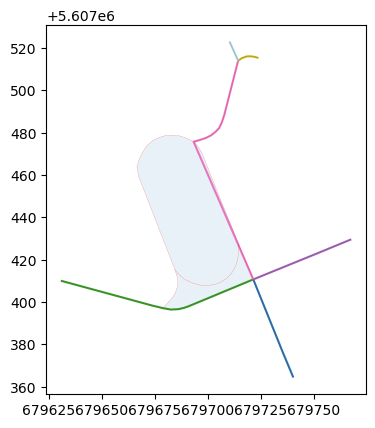

947


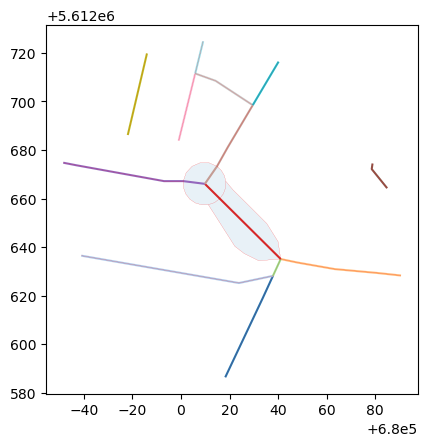

950


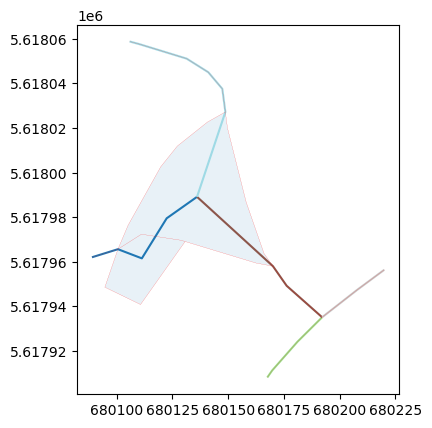

954


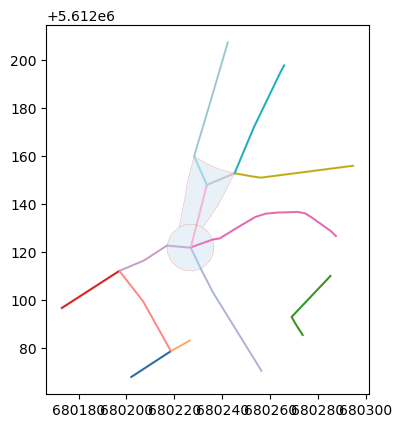

964


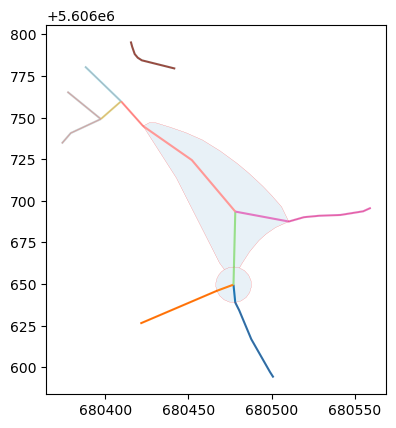

991


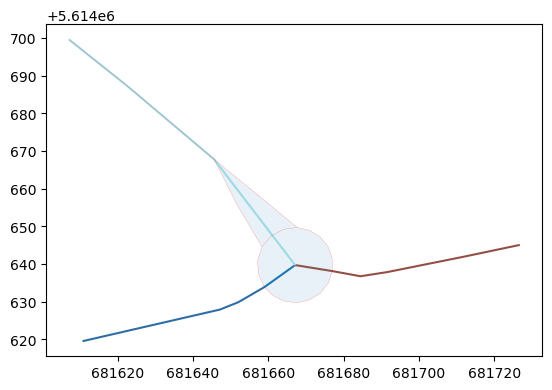

1001


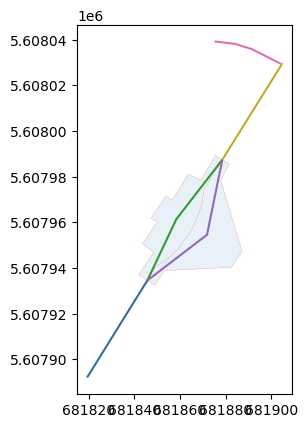

1008


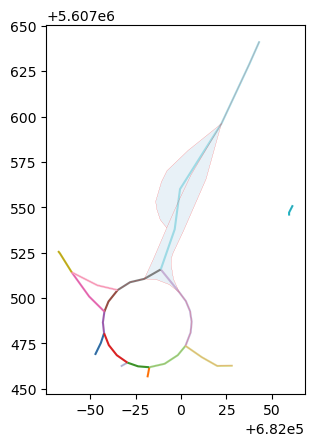

1016


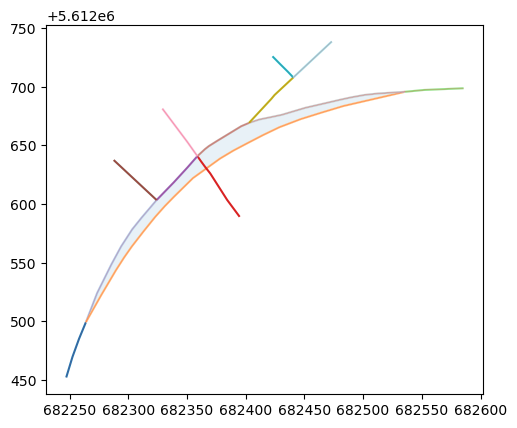

1019


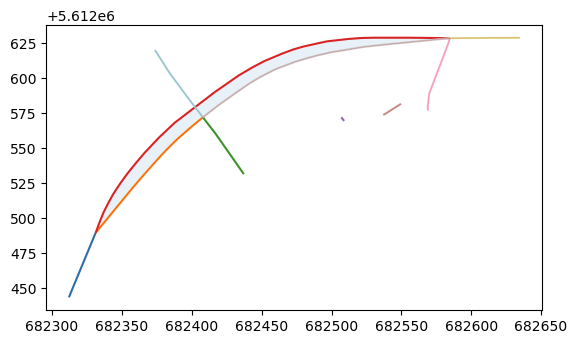

1023


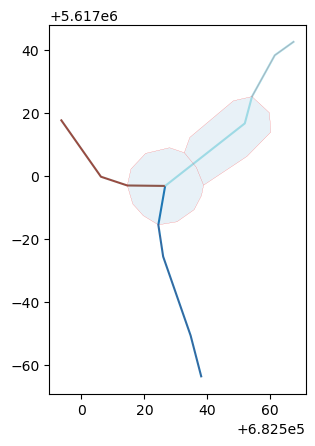

1058


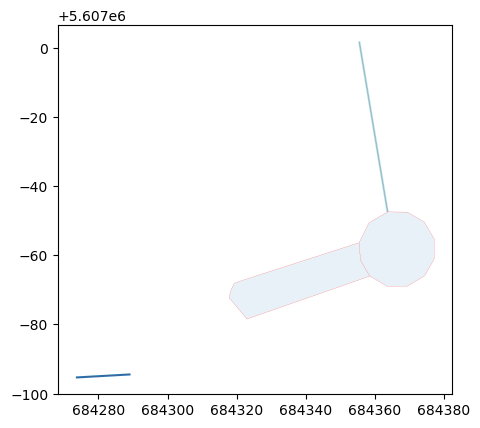

1120


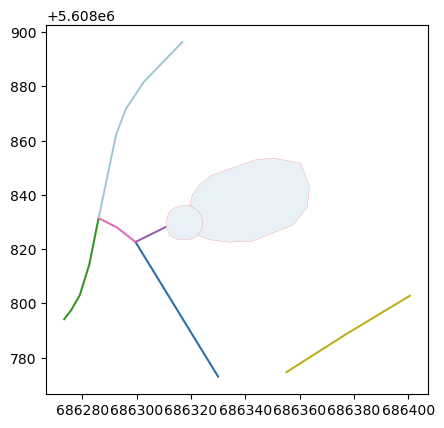

1141


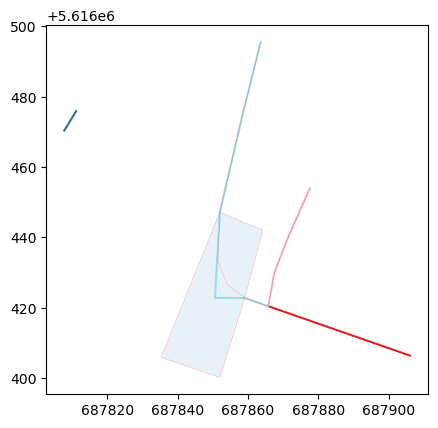

1149


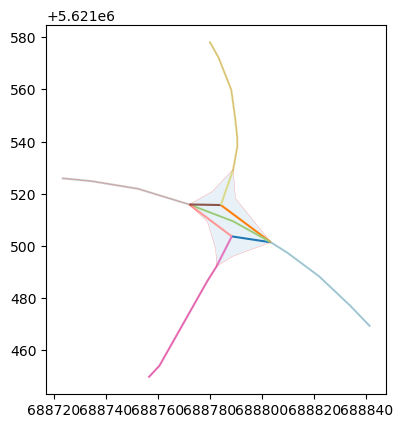

1161


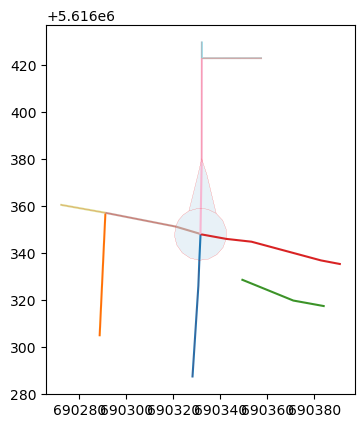

In [16]:
for artifact in data_sample.drop_duplicates("comp").itertuples():
    print(artifact.comp)

    # plot the results for visual verification
    geom = data_sample[data_sample.comp == artifact.comp]
    ax = new_roads.clip(geom.buffer(50)).plot(zorder=2, cmap="tab20")
    geom.plot(ax=ax, alpha=0.1)
    roads.clip(geom.buffer(50)).plot(
        color="red",
        ax=ax,
        # categorical=True,
        # legend=True,
        linewidth=0.1,
    )
    plt.show()

<Axes: >

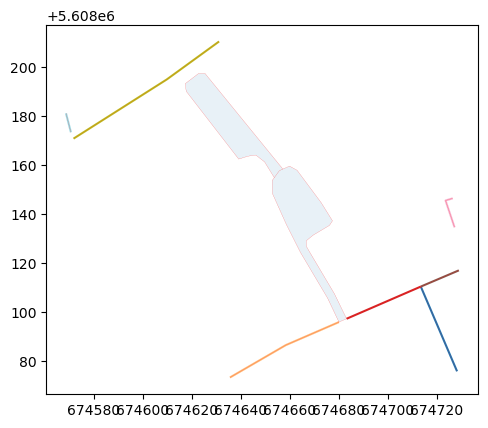

In [36]:
geom = artifacts
ax = loop_3.clip(geom.buffer(50)).plot(zorder=2, cmap="tab20")
geom.plot(ax=ax, alpha=0.1)
roads.clip(geom.buffer(50)).plot(
    color="red",
    ax=ax,
    # categorical=True,
    # legend=True,
    linewidth=0.1,
)

<Axes: >

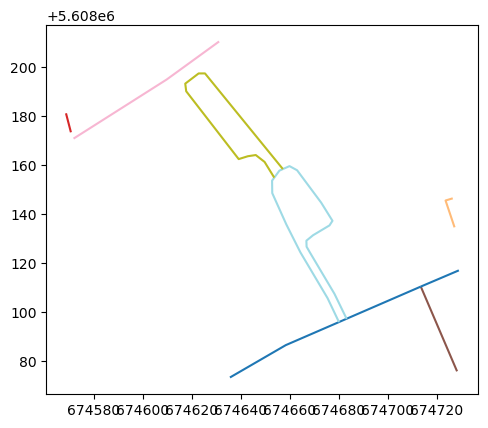

In [37]:
roads_cleaned.clip(geom.buffer(50)).plot("coins_group", categorical=True,cmap="tab20")

<Axes: >

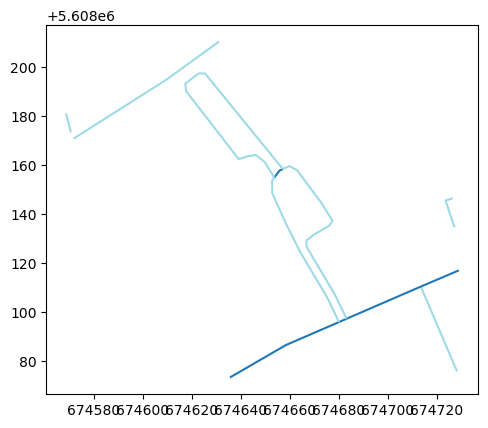

In [38]:
roads_cleaned.clip(geom.buffer(50)).plot("coins_end", cmap="tab20")

In [39]:
artifacts_w_info

geometry  face_artifact_index  \
3740  POLYGON ((674683.26 5608097.314, 674680.139 56...             4.504329   
4936  POLYGON ((674653.713 5608154.962, 674649.759 5...             4.661112   

        id  comp  node_count  stroke_count  C  E  S  non_planar  \
3740  3740   588           4             2  1  0  1       False   
4936  4936   588           2             2  1  0  1       False   

      non_planar_cluster  solution  drop_id  
3740                   0  skeleton  11641.0  
4936                   0  skeleton  11641.0

In [40]:
nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(loop_2)), lines=False)


In [41]:
cluster_geom = artifacts.union_all(method="coverage")

In [42]:
        edges = loop_2.iloc[
            loop_2.sindex.query(cluster_geom, predicate="intersects")
        ].copy()

<Axes: >

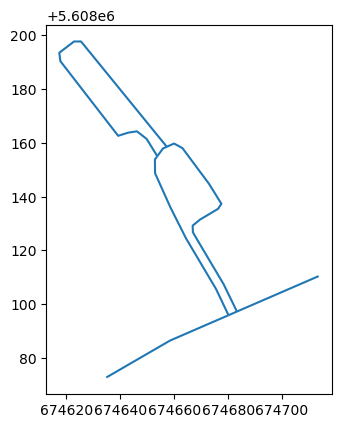

In [44]:
edges.plot()

In [53]:
edges.length

11804.0     50.978137
6048.0       3.405243
6047.0      33.039420
11800.0     65.997741
11805.0     81.452465
11802.0      5.104872
11781.0    117.339067
dtype: float64

In [45]:
eps = 1e-6

In [46]:
    # get edges on boundary
    edges_on_boundary = edges.intersection(cluster_geom.boundary.buffer(eps)).explode(
        ignore_index=True
    )
    edges_on_boundary = edges_on_boundary[
        (~edges_on_boundary.is_empty)
        & (edges_on_boundary.geom_type.str.contains("Line"))
        & (edges_on_boundary.length > 10 * eps)
    ]  # keeping only (multi)linestrings of length>>eps
    edges_on_boundary = edges_on_boundary.to_frame("geometry")

    # find nodes ON the cluster polygon boundary (to be partially kept)
    nodes_on_boundary = nodes.iloc[
        nodes.sindex.query(cluster_geom.boundary.buffer(eps), predicate="intersects")
    ].copy()

    # find edges that cross but do not lie within
    edges_crossing = edges.iloc[
        edges.sindex.query(cluster_geom.buffer(eps), predicate="crosses")
    ]

    # the nodes to keep are those that intersect with these crossing edges
    nodes_to_keep = nodes_on_boundary.iloc[
        nodes_on_boundary.sindex.query(
            edges_crossing.union_all(), predicate="intersects"
        )
    ].copy()

    # merging lines between nodes to keep:
    buffered_nodes_to_keep = nodes_to_keep.buffer(eps).union_all()

    # make queen contiguity graph on MINUSBUFFERED outline road segments,
    # and copy component labels into edges_on_boundary gdf
    edges_on_boundary = edges_on_boundary.explode(ignore_index=True)
    queen = graph.Graph.build_fuzzy_contiguity(
        edges_on_boundary.difference(buffered_nodes_to_keep)
    )
    edges_on_boundary["comp"] = queen.component_labels

<Axes: >

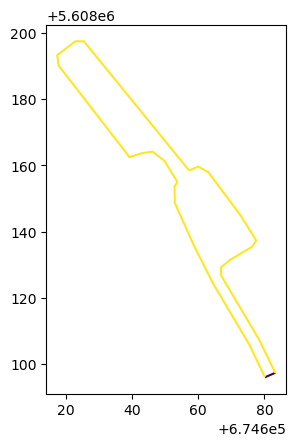

In [47]:
edges_on_boundary.plot("comp")

In [50]:
    skel, _ = voronoi_skeleton(
        edges_on_boundary.dissolve(by="comp").geometry,
        cluster_geom,
        snap_to=False,
        distance=1,
    )

<Axes: >

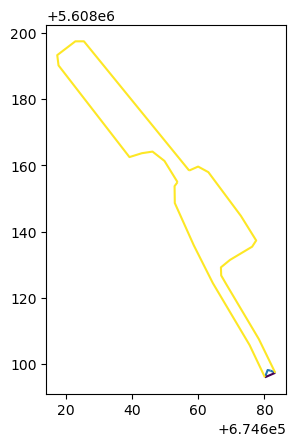

In [51]:
ax = gpd.GeoSeries(skel).plot()
edges_on_boundary.plot("comp", ax=ax)

In [35]:
buffer = None
poly = cluster_geom
lines = edges_on_boundary.dissolve(by="comp").geometry

In [58]:
    if buffer is None:
        buffer = distance * 20
    if not poly:
        poly = shapely.box(*lines.total_bounds)
    # get an additional line around the lines to avoid infinity issues with Voronoi
    extended_lines = list(lines) + [poly.buffer(buffer).exterior]

    # interpolate lines to represent them as points for Voronoi
    shapely_lines = extended_lines
    points, ids = shapely.get_coordinates(
        shapely.segmentize(shapely_lines, distance / 2), return_index=True
    )

    # remove duplicated coordinates
    unq, count = np.unique(points, axis=0, return_counts=True)
    mask = np.isin(points, unq[count > 1]).all(axis=1)
    points = points[~mask]
    ids = ids[~mask]

    # generate Voronoi diagram
    voronoi_diagram = spatial.Voronoi(points)

    # get all rigdes and filter only those between the two lines
    pts = voronoi_diagram.ridge_points
    mapped = np.take(ids, pts)
    rigde_vertices = np.array(voronoi_diagram.ridge_vertices)

    # iterate over segment-pairs and keep rigdes between input geometries
    edgelines = []
    to_add = []
    splitters = []

    # determine the negative buffer distance to avoid overclipping of narrow polygons
    # this can still result in some missing links, but only in rare cases
    dist = min([distance, shapely.ops.polylabel(poly).distance(poly.boundary) * 0.4])
    limit = poly.buffer(-dist)

    # drop ridges that are between points coming from the same line
    selfs = mapped[:, 0] == mapped[:, 1]
    buff = (mapped == mapped.max()).any(axis=1)
    mapped = mapped[~(selfs | buff)]
    rigde_vertices = rigde_vertices[~(selfs | buff)]
    unique = np.unique(np.sort(mapped, axis=1), axis=0)

    for a, b in unique:
        mask = ((mapped[:, 0] == a) | (mapped[:, 0] == b)) & (
            (mapped[:, 1] == a) | (mapped[:, 1] == b)
        )

        verts = rigde_vertices[mask]

        # generate the line in between the lines
        edgeline = shapely.line_merge(
            shapely.multilinestrings(voronoi_diagram.vertices[verts])
        )
        print(edgeline)

        # check if the edgeline is within polygon
        if not edgeline.within(poly):
            # if not, clip it by the polygon with a small negative buffer to keep
            # the gap between edgeline and poly boundary to avoid possible
            # overlapping lines
            edgeline = shapely.intersection(edgeline, limit)

        # check if a, b lines share a node
        intersection = shapely_lines[b].intersection(shapely_lines[a])
        # if they do, add shortest line from the edgeline to the shared node and
        # combine it with the edgeline
        if not intersection.is_empty:
            # we need union of edgeline and shortest because snap is buggy in GEOS
            # and line_merge as well. This results in a MultiLineString but we can
            # deal with those later. For now, we just need this extended edgeline to
            # be a single geometry to ensure the component discovery below works as
            # intended
            # get_parts is needed as in case of voronoi based on two lines, these
            # intersect on both ends, hence both need to be extended
            edgeline = shapely.union(
                edgeline, shapely.union_all(shapely.shortest_line(shapely.get_parts(intersection), edgeline.boundary))
            )
        # add final edgeline to the list
        edgelines.append(edgeline)

    edgelines = np.array(edgelines)[~(shapely.is_empty(edgelines))]

LINESTRING (682185.7967416324 5608395.344744597, 682200.6252922784 5608379.65660725, 682201.534814005 5608378.720846547, 682202.4443357316 5608377.785085845, 682203.353857458 5608376.849325142, 682204.2633791844 5608375.91356444, 682205.17290091 5608374.977803737, 682206.0824226376 5608374.042043034, 682206.9919443637 5608373.106282332, 682207.9014660907 5608372.170521628, 682208.8109878165 5608371.234760927, 682209.6943570734 5608370.298503371, 682209.9940467328 5608370.009086059, 682210.6038788018 5608369.362742667, 682210.9284354661 5608369.046969534, 682211.4510969665 5608368.493015708, 682210.4279184907 5608367.453319503, 682209.453485569 5608366.481766786, 682208.6886371642 5608365.724370512, 682204.0747727124 5608361.487676953, 682203.6562962154 5608361.187498312, 682199.9777669492 5608357.848740942, 682199.5268337851 5608357.487746804, 682199.5429500665 5608357.395430909, 682199.6600289522 5608357.29455294, 682215.4386753311 5608335.013218273)


In [107]:
shapely.get_parts(intersection.geoms[0])

array([<POINT (682203.886 5608351.368)>], dtype=object)

<Axes: >

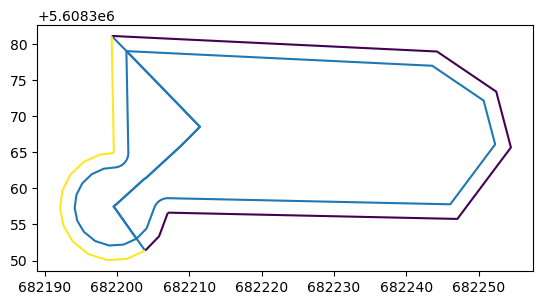

In [105]:
ax = gpd.GeoSeries(edgelines).plot()
edges_on_boundary.plot("comp", ax=ax)
gpd.GeoSeries([cluster_geom]).buffer(-2).boundary.plot(ax=ax)

In [42]:
edgeline = shapely.intersection(edgeline, limit)


In [44]:
intersection = shapely_lines[b].intersection(shapely_lines[a])

In [59]:
m = gpd.GeoSeries([edgeline]).explore(opacity=.5, style_kwds=dict(weight=10))
edges_on_boundary.set_crs(None, allow_override=True).explore(m=m)
# gpd.GeoSeries([intersection]).explore(m=m)
gpd.GeoSeries(shapely.shortest_line(shapely.get_parts(intersection), edgeline.boundary)).explore(m=m, color="red")
m

In [50]:
gpd.GeoSeries(shapely.shortest_line(shapely.get_parts(intersection), edgeline.boundary)).explore()

In [53]:
shapely.shortest_line(shapely.get_parts(intersection), edgeline.boundary)

array([<LINESTRING (682203.886 5608351.368, 682202.687 5608353.02)>,
       <LINESTRING (682199.248 5608381.06, 682201.303 5608378.959)>],
      dtype=object)